In [1]:
# 导入相关库
from pyspark.sql import Row, SparkSession,SQLContext
from pyspark.sql.types import IntegerType,DateType, TimestampType
from pyspark.sql.functions import col, udf,to_date,from_unixtime,countDistinct

# 计算处理
import pandas as pd
import numpy as np

import time

# 图表相关
import plotly.plotly as py
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

# jupyter使用matplot的配置
%matplotlib inline

In [2]:
# 创建spark上下文，并设置10个分区
spark = SparkSession.builder.appName("vas项目").config("spark.default.parallelism", 10).getOrCreate()
sc = spark.sparkContext

In [3]:
%%time

logPaths = ['/var/log/vas-project/vas_data/201807',
            '/var/log/vas-project/vas_data/201808', 
            '/var/log/vas-project/vas_data/201809',
            '/var/log/vas-project/vas_data/201810'
           ];
df = spark.read.format('json').load(logPaths)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 41.3 s


In [4]:
%%time

# 查看前10条数据

df.limit(10).show()

+-----+------------+------+--------------------+---------------+-----+-----------+---+
|brand|country_code|device|              events|     ip_address|model|    partner|ref|
+-----+------------+------+--------------------+---------------+-----+-----------+---+
| Itel|          ML|    sp|[[click, 15358391...|  217.64.103.74|  P13|searchturbo|  m|
| Itel|          EG|    sp|[[click, 15358391...|196.141.135.133| A32F|searchturbo|  m|
| Itel|          NG|    sp|[[click, 15358391...| 197.210.226.58|  P32|searchturbo|  m|
| Itel|          IN|    sp|[[click, 15358391...| 157.48.123.237|  A22|searchturbo|  m|
| Itel|          EG|    sp|[[click, 15358391...|  105.199.93.33| A32F|searchturbo|  m|
| Itel|          EG|    sp|[[click, 15358391...|196.141.135.133| A32F|searchturbo|  m|
| Itel|          MA|    sp|[[click, 15358391...| 41.249.147.213| A32F|searchturbo|  m|
| Itel|          CI|    sp|[[click, 15358391...|   154.0.26.115|  P32|    Unknown|  m|
| Itel|          BJ|    sp|[[click, 1535839

In [5]:
%%time

# 查看总共记录数

df.count()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.31 s


2075513

## 例1. 按品牌机型统计

In [6]:
%%time

# 按照品牌(brand)和机型(model)进行聚合

brand_model_count = df.select('brand', 'partner', 'model').groupBy('brand','model').count()

# 打印一下
brand_model_count.show()

+-----+---------+------+
|brand|    model| count|
+-----+---------+------+
| Itel|     A52B|    19|
| Itel|      A14| 10136|
| Itel|  S13 Pro|   151|
| Itel| A16 Plus|   229|
| Itel|      A52| 12812|
| Itel|      A45| 68690|
| Itel|      A22| 69811|
| Itel|      A16|  4210|
| Itel|     S11X| 27366|
| Itel|      A62| 11161|
|Spice|     Z213| 77393|
| Itel|    S11XB|   137|
| Itel|      A15| 11744|
| Itel|      P32|550753|
| Itel| P13 Plus|   176|
| Itel|A44 Power|    32|
| Itel|     A32F|537792|
| Itel|itel A32F| 67001|
| Itel|      A23|  1493|
| Itel|      S13| 19634|
+-----+---------+------+
only showing top 20 rows

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 10.8 s


In [7]:
%%time

# 换行成pandas

pd_df = brand_model_count.toPandas()

# 查看前5条
pd_df.head(5)

CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 10.1 s


In [8]:
# 数据转换，排序处理下

pd_df.index = pd_df['brand'] + '_' + pd_df['model']
pd_df = pd_df.sort_values(by = ['brand', 'count'])

pd_df.head()

,brand,model,count
Itel_S13Pro,Itel,S13Pro,3
Itel_A52B,Itel,A52B,19
Itel_A44 Power,Itel,A44 Power,32
Itel_S11XB,Itel,S11XB,137
Itel_S13 Pro,Itel,S13 Pro,151


In [9]:
# 只取count列
pd_df = pd_df[['count']]

# 查看一下
pd_df.head()

,count
Itel_S13Pro,3
Itel_A52B,19
Itel_A44 Power,32
Itel_S11XB,137
Itel_S13 Pro,151


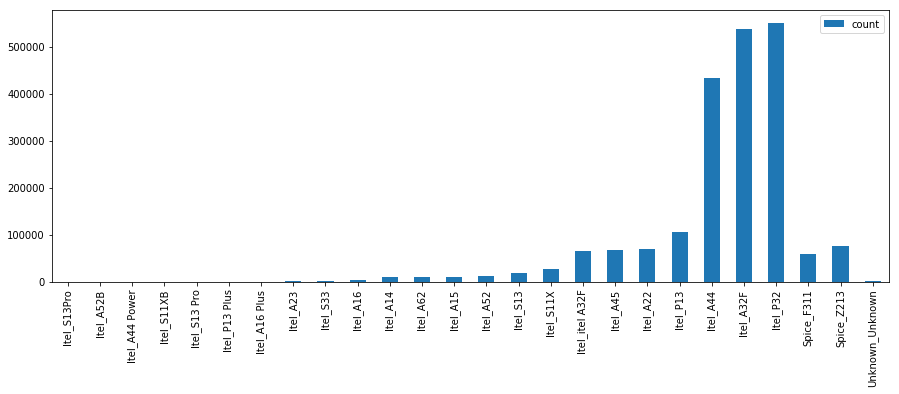

In [10]:
# 图表显示下

pd_df.plot(kind='bar', figsize=(15, 5))

## 例2. 按国家查看访问量

In [11]:
%%time
# 按照country_code 进行聚合

country_code_count = df.select('country_code').groupBy('country_code').count()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 62.6 ms


In [12]:
%%time
# 显示前5条数据

country_code_count.limit(5).collect()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 7.5 s


[Row(country_code='DZ', count=1027),
 Row(country_code='LT', count=12),
 Row(country_code='MM', count=18),
 Row(country_code='CI', count=95814),
 Row(country_code='SC', count=8)]

In [13]:
# 转换成pandas

codePandas = country_code_count.toPandas()

codePandas.head()

,country_code,count
0,DZ,1027
1,LT,12
2,MM,18
3,CI,95814
4,SC,8


In [14]:
# 按照访问量排序下

codePandas = codePandas.sort_values(by='count', ascending=False)

codePandas.head(10)

,country_code,count
74,IN,440134
139,NG,432983
58,Unknown,309625
39,BD,192363
146,VN,96927
3,CI,95814
130,MA,69185
33,GH,49175
77,CM,44962
115,SN,42320


In [15]:
# 图表展示下

codes = {}
for code in codePandas.values[:30]:
    codes[code[0].lower()] = code[1]
    
import pygal
from ipywidgets import HTML
import base64
worldmap_chart = pygal.maps.world.World()
worldmap_chart.title = '访问量最多的30个国家'
worldmap_chart.add('访问量top30', codes)
b64 = base64.b64encode(worldmap_chart.render())
src = 'data:image/svg+xml;charset=utf-8;base64,'+b64.decode("utf-8")
HTML('<embed src={}></embed>'.format(src))

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

## 例3. 每小时访问量走势图

In [16]:
%%time

# 增加3个栏位， timestamp, hour, month

df = df.withColumn('timestamp', df.events[0].timestamp)
df = df.withColumn('hour', from_unixtime(df.events[0].timestamp, 'HH'))
df = df.withColumn('month', from_unixtime(df.events[0].timestamp, 'yyyy-MM'))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 387 ms


In [17]:
%%time

# 按照小时聚合下

group_by_hour = df.select('hour').groupBy('hour').count()
df.show(10)

+-----+------------+------+--------------------+---------------+-----+-----------+---+----------+----+-------+
|brand|country_code|device|              events|     ip_address|model|    partner|ref| timestamp|hour|  month|
+-----+------------+------+--------------------+---------------+-----+-----------+---+----------+----+-------+
| Itel|          ML|    sp|[[click, 15358391...|  217.64.103.74|  P13|searchturbo|  m|1535839148|  05|2018-09|
| Itel|          EG|    sp|[[click, 15358391...|196.141.135.133| A32F|searchturbo|  m|1535839156|  05|2018-09|
| Itel|          NG|    sp|[[click, 15358391...| 197.210.226.58|  P32|searchturbo|  m|1535839161|  05|2018-09|
| Itel|          IN|    sp|[[click, 15358391...| 157.48.123.237|  A22|searchturbo|  m|1535839162|  05|2018-09|
| Itel|          EG|    sp|[[click, 15358391...|  105.199.93.33| A32F|searchturbo|  m|1535839163|  05|2018-09|
| Itel|          EG|    sp|[[click, 15358391...|196.141.135.133| A32F|searchturbo|  m|1535839164|  05|2018-09|
|

In [18]:
%%time
# dataframe 转换成padnas
group_by_hour_pandas_df = group_by_hour.toPandas()

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 10.4 s


In [19]:
# 按照访问量进行排序下
group_by_hour_pandas_df = group_by_hour_pandas_df.sort_values(by='hour')

# 强制转换整数类型
group_by_hour_pandas_df.hour = group_by_hour_pandas_df['hour'].map(int)

# 将小时设置pandas索引
group_by_hour_pandas_df.index = group_by_hour_pandas_df.hour

group_by_hour_pandas_df.head(5)

,hour,count
hour,,
0,0,118156
1,1,112722
2,2,85696
3,3,85365
4,4,77598


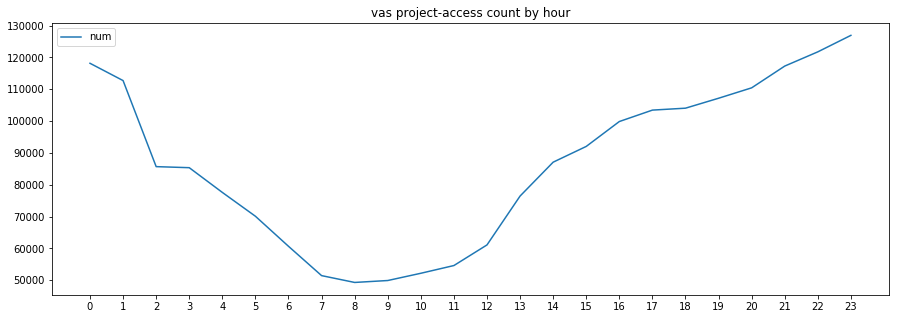

In [20]:
# 画个图表
hourcount = (group_by_hour_pandas_df.to_dict())['count']
index = list(range(0,24))
cols = []
for i in index:
    if i not in hourcount:
        cols.append(0)
    else:
        cols.append(hourcount[i])

group_by_hour_pandas_df = pd.DataFrame({'num': cols})


group_by_hour_pandas_df.plot(title='vas project-access count by hour', kind='line', figsize=(15, 5), xticks=group_by_hour_pandas_df.index)

## 例4. 每个月访问量

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 10.3 s


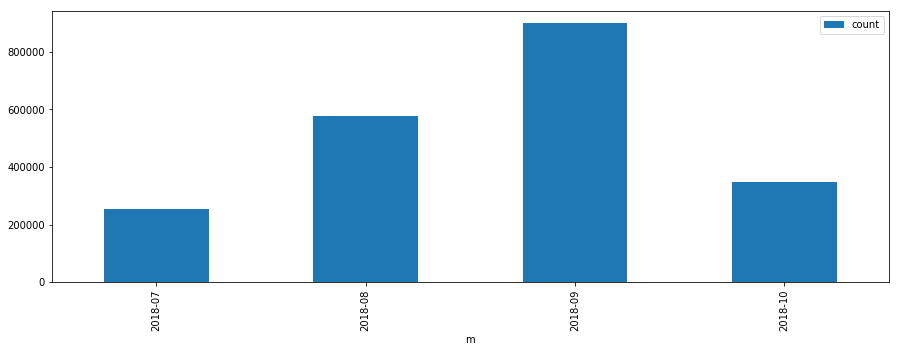

In [21]:
%%time
group_by_month =df.select('month').groupBy('month').count()

group_by_month_pandas = group_by_month.limit(5).toPandas()
group_by_month_pandas.index = group_by_month_pandas['month']
group_by_month_pandas.index.name = 'm';
group_by_month_pandas = group_by_month_pandas.sort_values(by='month', ascending=True)

## 每月uv
group_by_month_pandas[['count']].plot(kind='bar', figsize=(15, 5))